In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter

In [2]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [3]:
dataset = torchvision.datasets.ImageFolder(root="../data/3rd_dataset_chest_xray_covid19_pneumonia", 
                                 transform = None,
                                 target_transform = None,
                                 )

In [4]:
len(dataset)

6432

In [5]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4849})

In [6]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

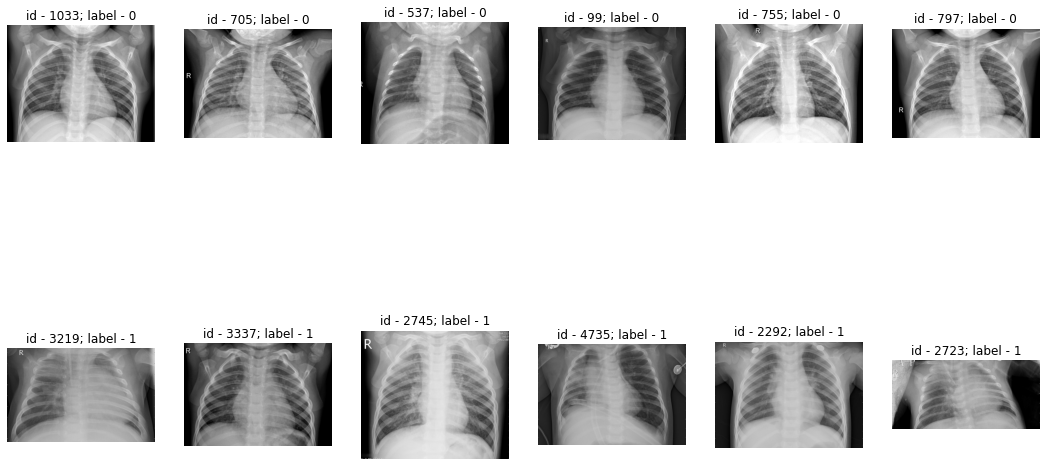

In [7]:
visualize_classes(dataset)

In [8]:
dataset = torchvision.datasets.ImageFolder(
    root="../data/chest_xray", 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [9]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

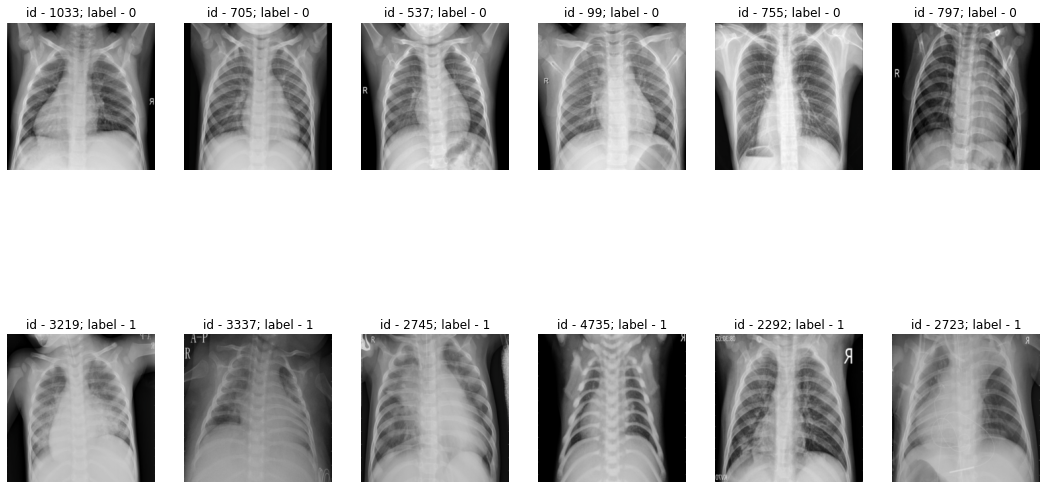

In [10]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [11]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [12]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=2
)

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Train model

In [14]:
def epoch(loader, model, device, criterion, opt=None):
    probabilities = []
    all_labels = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * inputs.size(0)
        all_labels.extend(list(labels.cpu().detach().numpy().reshape(-1)))
        probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))
    return total_loss / float(len(loader.dataset)), all_labels, probabilities

In [15]:
def print_metrics(writer, phase, epoch_num, loss, labels, prob, lr=None):
    acc = accuracy_score(labels, (np.array(prob) > 0.5).astype(int))
    ap = average_precision_score(labels, prob)

    writer.add_scalar(f'Loss', loss, epoch_num)
    writer.add_scalar(f'Accuracy', acc, epoch_num)
    writer.add_scalar(f'Average precision', ap, epoch_num)
    if lr is not None:
        writer.add_scalar(f'LR', lr, epoch_num)
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f} LR: {lr}")
    else:
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f}")

In [16]:
def create_writers(log_dir: str = "./runs"):
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    train_log_dir = f"{log_dir}/{current_time}/train/"
    val_log_dir = f"{log_dir}/{current_time}/val/"
    train_writer = SummaryWriter(log_dir=train_log_dir)
    val_writer = SummaryWriter(log_dir=val_log_dir)
    return train_writer, val_writer

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    train_writer, val_writer = create_writers("../runs")
    model.train()

    for epoch_num in range(num_epochs):
        print(f"Epoch {epoch_num}/{num_epochs - 1}")
        print("-" * 10)

        train_loss, train_labels, train_prob = epoch(train_loader, model, device, criterion, opt = optimizer)
        val_loss, val_labels, val_prob = epoch(test_loader, model, device, criterion)

        print_metrics(train_writer, "train", epoch_num, train_loss, train_labels, train_prob, optimizer.param_groups[0]["lr"])
        print_metrics(val_writer, "val", epoch_num, val_loss, val_labels, val_prob)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch_num
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:4f} Best epoch: {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
device = "cuda:0"
# device = "cpu"

In [19]:
model_ft = models.resnet18(pretrained=True)

model_ft.fc = nn.Sequential(
    nn.Linear(model_ft.fc.in_features, 2),
    nn.Softmax(),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=5, eps=1e-07)

In [21]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.3825 Acc: 0.9268 AP: 0.9849 LR: 0.001
val Loss: 0.3913 Acc: 0.9198 AP: 0.9739

Epoch 1/14
----------
train Loss: 0.3883 Acc: 0.9223 AP: 0.9742 LR: 0.001
val Loss: 0.3947 Acc: 0.9147 AP: 0.9770

Epoch 2/14
----------
train Loss: 0.3800 Acc: 0.9325 AP: 0.9815 LR: 0.001
val Loss: 0.3926 Acc: 0.9224 AP: 0.9523

Epoch 3/14
----------
train Loss: 0.3788 Acc: 0.9325 AP: 0.9807 LR: 0.001
val Loss: 0.3700 Acc: 0.9437 AP: 0.9887

Epoch 4/14
----------
train Loss: 0.3837 Acc: 0.9266 AP: 0.9810 LR: 0.001
val Loss: 0.4016 Acc: 0.9078 AP: 0.9643

Epoch 5/14
----------
train Loss: 0.3835 Acc: 0.9293 AP: 0.9777 LR: 0.001
val Loss: 0.3884 Acc: 0.9232 AP: 0.9700

Epoch 6/14
----------
train Loss: 0.3751 Acc: 0.9389 AP: 0.9797 LR: 0.001
val Loss: 0.3819 Acc: 0.9317 AP: 0.9806

Epoch 7/14
----------
train Loss: 0.3793 Acc: 0.9317 AP: 0.9846 LR: 0.001
val Loss: 0.3632 Acc: 0.9488 AP: 0.9886

Epoch 8/14
----------
train Loss: 0.3753 Acc: 0.9360 AP: 0.9820 LR: 0.001
val Lo

### Analyze results

In [22]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model_ft.eval()
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model_ft(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 37/37 [00:06<00:00,  5.81it/s]


In [23]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [24]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [25]:
df["error_type"] = df.apply(error_class, axis=1)

In [26]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,22,22,22
FP,28,28,28
TN,279,279,279
TP,843,843,843


In [27]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.9573378839590444
average_precision_score - 0.9620084580066477


In [28]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [29]:
df

,true,pred,prob,error_type
0,1,1,9.991404e-01,TP
1,1,1,9.903301e-01,TP
2,0,0,5.349105e-08,TN
3,1,1,9.992715e-01,TP
4,0,0,3.160269e-04,TN
...,...,...,...,...
1167,0,0,2.356118e-12,TN
1168,0,1,6.390400e-01,FP
1169,1,0,2.535620e-02,FN
1170,1,1,9.980496e-01,TP


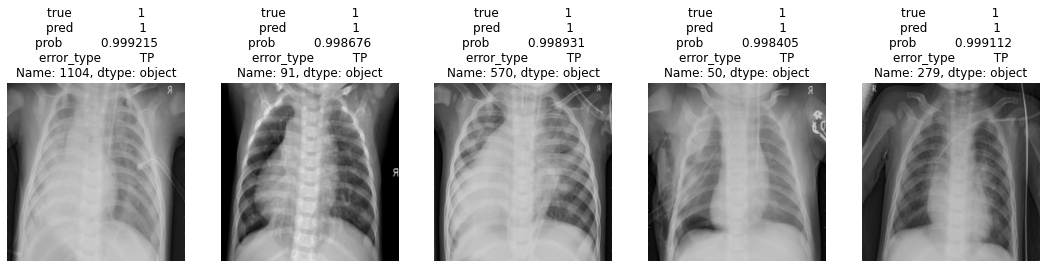

In [30]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

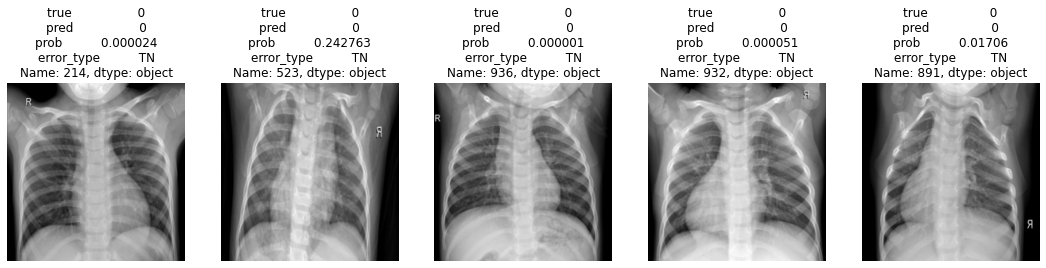

In [31]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

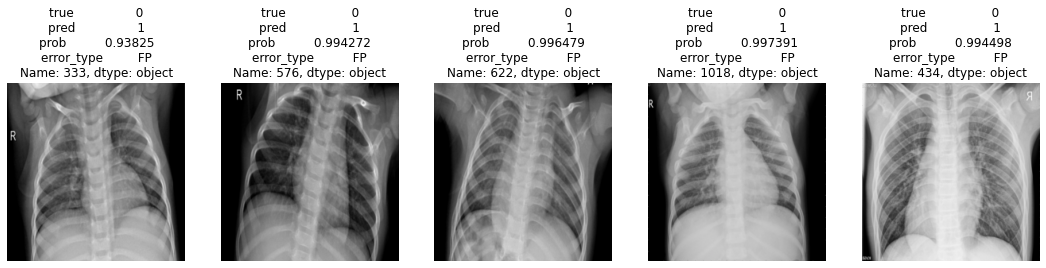

In [32]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

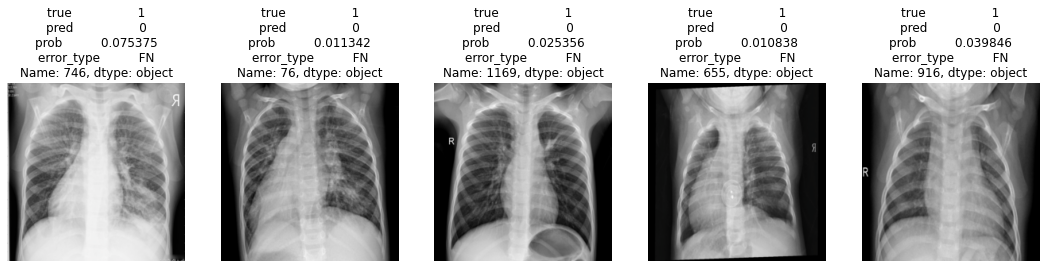

In [33]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Save model

In [34]:
save_path = f"../models/4.3_resnet18_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
torch.save(model_ft.state_dict(), save_path)
save_path

'../models/4.3_resnet18_2021-04-13_01:45:53.pt'

In [35]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  